In [1]:
import poppy

In [2]:
p = 7
n = 2
f = poppy.field(p,n)
a = poppy.random((2,2,2),f)

print(f'a.lift()\n{a.lift()}\n')
print(f'a.proj()\n{a.proj()}\n')
print(f'a.t().proj()\n{a.t().proj()}\n')
print(f'a.inv().proj()\n{a.inv().proj()}\n') 
print(f'(a@a.inv()).proj()\n{(a@a.inv()).proj()}\n')
print(f'a.trace().proj()\n{a.trace().proj()}\n')
print(f'a.det().proj()\n{a.det().proj()}\n')
print(f'a.rank()\n{a.rank()}\n')
print(f'a.ker().proj()\n{a.ker().proj()}\n')
print(f'a.im().proj()\n{a.im().proj()}\n')
print(f'a.mod(a).proj()\n{a.mod(a).proj()}\n')
print(f'a.dirsum(a).proj()\n{a.dirsum(a).proj()}\n')

a.lift()
[[[[[1 5]
    [6 6]]

   [[4 3]
    [5 0]]]


  [[[6 4]
    [2 3]]

   [[6 0]
    [0 6]]]]



 [[[[5 1]
    [4 6]]

   [[5 0]
    [0 5]]]


  [[[0 5]
    [6 5]]

   [[1 1]
    [4 2]]]]]

a.proj()
[[[36 25]
  [34  6]]

 [[12  5]
  [35  8]]]

a.t().proj()
[[[36 34]
  [25  6]]

 [[12 35]
  [ 5  8]]]

a.inv().proj()
[[[16 46]
  [ 2 42]]

 [[21 33]
  [16 31]]]

(a@a.inv()).proj()
[[[1 0]
  [0 1]]

 [[1 0]
  [0 1]]]

a.trace().proj()
[[[35 20]]]

a.det().proj()
[[[39 23]]]

a.rank()
[2 2]

a.ker().proj()
[[[0 0]
  [0 0]]

 [[0 0]
  [0 0]]]

a.im().proj()
[[[36 25]
  [34  6]]

 [[12  5]
  [35  8]]]

a.mod(a).proj()
[[[0 0]
  [0 0]]

 [[0 0]
  [0 0]]]

a.dirsum(a).proj()
[[[36 25  0  0]
  [34  6  0  0]
  [ 0  0 36 25]
  [ 0  0 34  6]]

 [[12  5  0  0]
  [35  8  0  0]
  [ 0  0 12  5]
  [ 0  0 35  8]]]



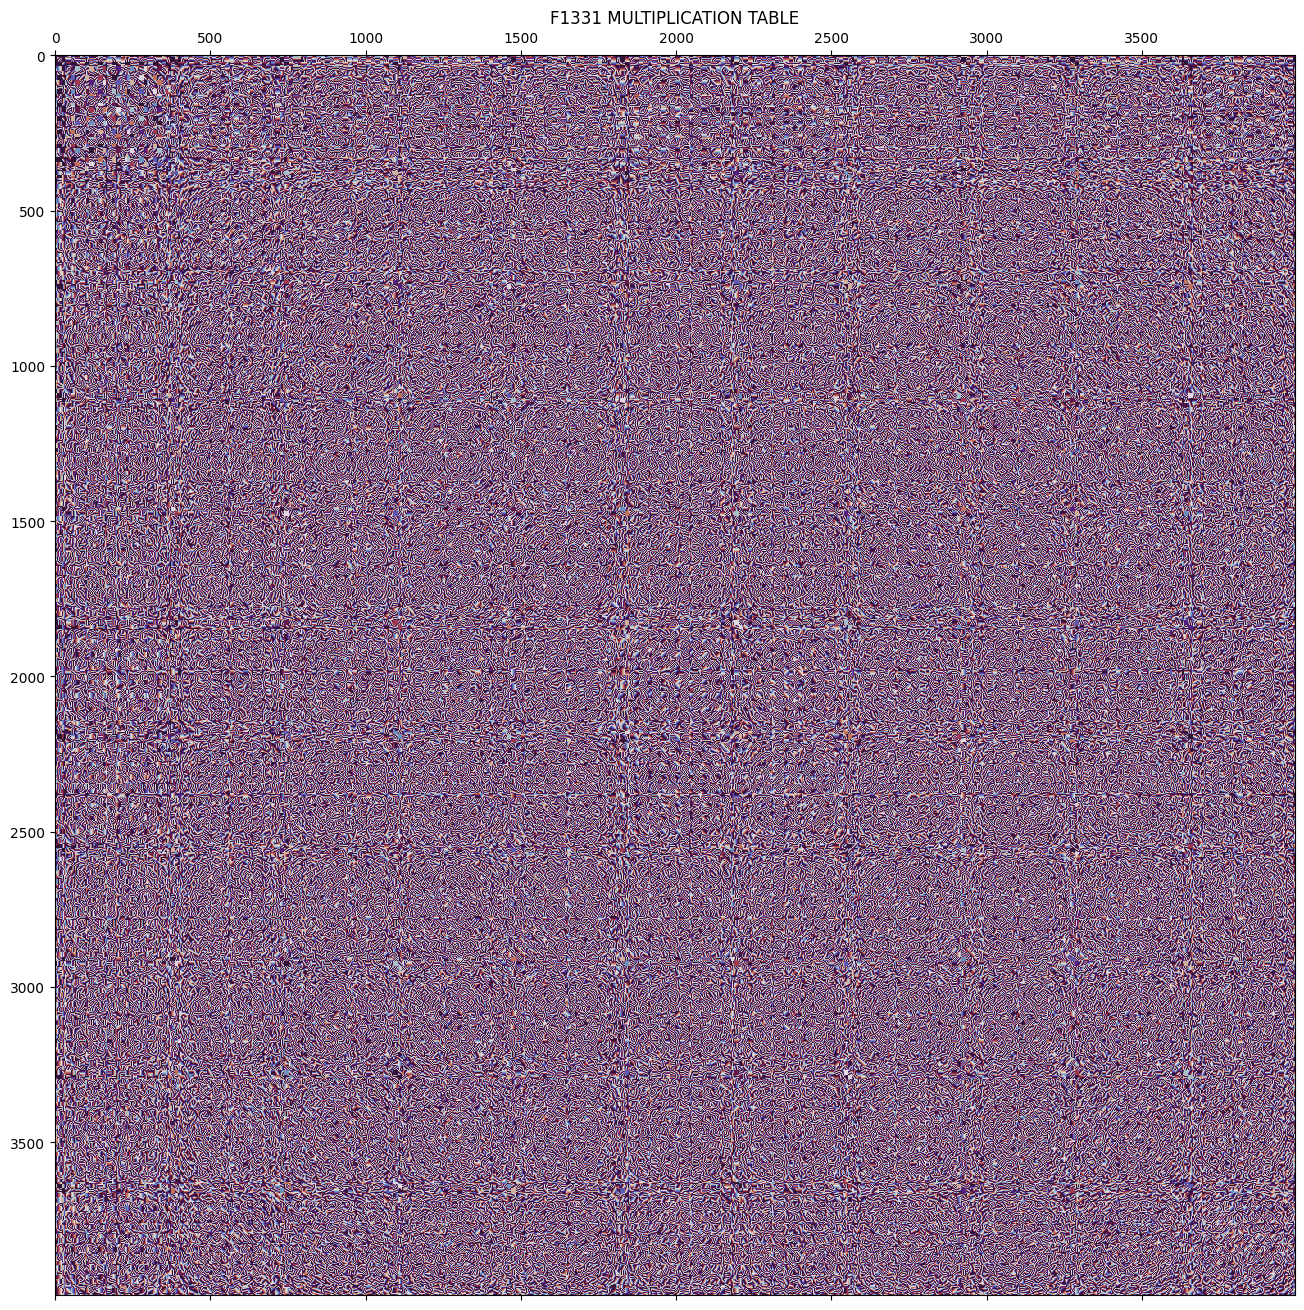

In [3]:
p,n = 11,3
f = poppy.field(p,n)
F = poppy.arange(f.q,f)

poppy.plot(poppy.unblock(F.dirprod(F.t()).lift(),f).reshape((f.q*n,f.q*n)), title = f'F{f.q} MULTIPLICATION TABLE', size = 50)

In [4]:
p = 23
q = 17
lps, i = poppy.lps(p,q)

print(f'LPS EXPANDER GRAPH ({p} {q})')
print(lps)
print(i)

LPS EXPANDER GRAPH (23 17)
[[65111 65383 60249 ... 61779 67831 67559]
 [32777 28901 81856 ... 41226 36466  8994]
 [28051 71146 13567 ... 75804 10524 38217]
 ...
 [82332  4200 72336 ... 50355 30278 81193]
 [41209  4557 36381 ... 54588 36976 58328]
 [55438  2279 79884 ... 79510 28493 50576]]
[83521 83521 83521 ... 83521 83521 83521]


In [5]:
p = 7
n = 3
deg = 128
f = poppy.field(p,n)
polygon = poppy.polygon(deg,f)

print(poppy.betti(polygon))

(Array([1], dtype=int64), Array([0], dtype=int64), Array([0], dtype=int64))


In [6]:
p = 11
n = 2
deg = 4
perm = [0,1,2,3,4,5,6,7]
f = poppy.field(p,n)
graph = poppy.graph(deg,perm,f)

print(poppy.euler(graph))
print(poppy.betti(graph))

[0]
(Array([1], dtype=int64), Array([2], dtype=int64), Array([1], dtype=int64))
